In [1]:
from my_library import *

In [2]:
customers = pd.read_csv('../Data_e-commerce/olist_customers_dataset.csv')
geolocation = pd.read_csv('../Data_e-commerce/olist_geolocation_dataset.csv')
order_items = pd.read_csv('../Data_e-commerce/olist_order_items_dataset.csv')
order_payments = pd.read_csv('../Data_e-commerce/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('../Data_e-commerce/olist_order_reviews_dataset.csv')
orders = pd.read_csv('../Data_e-commerce/olist_orders_dataset.csv')
products = pd.read_csv('../Data_e-commerce/olist_products_dataset.csv')
sellers = pd.read_csv('../Data_e-commerce/olist_sellers_dataset.csv')

# product_category 이름 English로 번역
name_translation = pd.read_csv('../Data_e-commerce/product_category_name_translation.csv')

In [3]:
import os

dir_path = "../Data_e-commerce"

total_data_lst2, data_lst = [], []

for (root, directories, files) in os.walk(dir_path):
    for file in files:
        file_path = os.path.join(root, file)
        data_lst.append(file_path.split('_')[2:-1])


for i in data_lst :
    total_data_lst2.append('_'.join(i))

print(total_data_lst2)

['preprocessing', 'preprocessing', 'preprocessing', 'customers', 'geolocation', 'orders', 'order_items', 'order_payments', 'order_reviews', 'products', 'sellers', 'category_name']


In [4]:
total_data_lst = [customers, geolocation, orders, order_items, order_payments, order_reviews, products, sellers, name_translation]

total_data_lst2.remove('category_name') 
total_data_lst2.append('name_translation')

In [5]:
for idx, value in enumerate(total_data_lst) :
    print(f'{total_data_lst2[idx]}: ', value.shape)

preprocessing:  (99441, 5)
preprocessing:  (1000163, 5)
preprocessing:  (99441, 8)
customers:  (112650, 7)
geolocation:  (103886, 5)
orders:  (99224, 7)
order_items:  (32951, 9)
order_payments:  (3095, 4)
order_reviews:  (71, 2)


# Dataset Merge

1. orders는 주문 상태, 배송에 관련된 데이터셋, 실제로 구매하여 배송받은 고객의 데이터이므로 이를 기준으로 merge 
2. 나머지 데이터는 outer를 사용하여 merge

In [6]:
# orders dataset을 기준으로 merge -> left 사용
df = orders.merge(order_items, on='order_id', how = 'left')

# 나머지 데이터는 outer를 사용하여 merge
df = df.merge(order_payments, on='order_id', how='outer')
df = df.merge(order_reviews, on='order_id', how='outer')
df = df.merge(products, on='product_id', how='outer')
df = df.merge(customers, on='customer_id', how='outer')
df = df.merge(sellers, on='seller_id', how='outer')

In [7]:
df.shape

(119143, 39)

In [8]:
# 데이터 통합한거 excel, csv로 저장
# df.to_excel(excel_writer = 'ecommerce_project_df.xlsx')
df.to_csv('../Data_e-commerce/ecommerce_project_df.csv', index=False)

# 컬럼 유형 확인 - 범주형, 연속형 등..

In [9]:
df = pd.read_csv('../Data_e-commerce/ecommerce_project_df.csv')

In [10]:
df.nunique()[df.nunique() == 8].keys().to_list()

['order_status']

In [11]:
id_cols = ['order_id', 'seller_id', 'customer_id', 'order_item_id', 'product_id', 
           'review_id', 'customer_unique_id', 'seller_zip_code_prefix']

# binary columns 확인
bin_cols = df.nunique()[df.nunique() == 2].keys().to_list()
# categorical columns 확인
    # state의 수가 27, 27이하는 categorical column으로
cat_cols = df.nunique()[df.nunique() <= 27].keys().tolist() 
# numerical columns 확인
num_cols = [x for x in df.columns if x not in cat_cols + id_cols]
# multi columns 확인
multi_cols = [x for x in cat_cols if x not in bin_cols]
print(len(id_cols), len(bin_cols), len(cat_cols), len(num_cols), len(multi_cols))

8 0 8 24 8


In [91]:
print(bin_cols)
print('')
print(cat_cols)
print('')
print(num_cols)
print('')
print(multi_cols)

[]

['order_status', 'order_item_id', 'payment_type', 'payment_installments', 'review_score', 'product_photos_qty', 'customer_state', 'seller_state']

['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date', 'price', 'freight_value', 'payment_sequential', 'payment_value', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'customer_zip_code_prefix', 'customer_city', 'seller_city']

['order_status', 'order_item_id', 'payment_type', 'payment_installments', 'review_score', 'product_photos_qty', 'customer_state', 'seller_state']


# 결측치 처리
1. 결측치는 아니지만, order_status가 delivered 경우의 데이터로만 분석을 진행하고자 하여 order_status가 delivered 아닌 경우 drop
    - 전체에서 2.87% drop
2. review 관련 columns 제외하고 나머지 결측치인 경우 drop
    - 1번 진행 후 전체에서 4.27% drop



In [92]:
df.isna().sum()[df.isna().sum() != 0]

order_approved_at                   177
order_delivered_carrier_date       2086
order_delivered_customer_date      3421
order_item_id                       833
product_id                          833
seller_id                           833
shipping_limit_date                 833
price                               833
freight_value                       833
payment_sequential                    3
payment_type                          3
payment_installments                  3
payment_value                         3
review_id                           997
review_score                        997
review_comment_title             105154
review_comment_message            68898
review_creation_date                997
review_answer_timestamp             997
product_category_name              2542
product_name_lenght                2542
product_description_lenght         2542
product_photos_qty                 2542
product_weight_g                    853
product_length_cm                   853


In [93]:
df['order_status'].unique()

array(['delivered', 'shipped', 'canceled', 'invoiced', 'processing',
       'unavailable', 'created', 'approved'], dtype=object)

In [94]:
# order_status가 delivered 경우의 데이터로만 분석을 진행하고자 하여 order_status가 delivered 아닌 경우 drop

print( 'order_status가 delivered 아닌 경우의 비율 :', round( df[df['order_status'] != 'delivered'].shape[0] / df['order_status'].shape[0] * 100 , 2) )
df['order_status'].value_counts()

order_status가 delivered 아닌 경우의 비율 : 2.87


delivered      115723
shipped          1256
canceled          750
unavailable       652
invoiced          378
processing        376
created             5
approved            3
Name: order_status, dtype: int64

In [95]:
# order_status가 delivered 경우의 데이터로만 분석을 진행하고자 하여 order_status가 delivered 아닌 경우 drop

df2 = df.copy()
df2 = df2.drop(df[df['order_status'] != 'delivered'].index)

# review 관련 결측치 값은 리뷰 분석(NLP)시 진행!
print('---결측치 제거 전---')
display(df2.isna().sum()[df2.isna().sum() != 0])

# product_category_name의 order_status가 전부 delivered지만, category별 데이터 분석을 진행하고자 해당 결측치는 drop

df2[df2.product_category_name.isna()]['order_status'].value_counts()
df2 = df2.drop(df2[df2.product_category_name.isna()].index)


# review 관련 columns 제외하고 나머지 결측치인 경우 drop

nan_col_lst = df2.isna().sum()[df2.isna().sum() != 0].index

for i in nan_col_lst[~nan_col_lst.str.contains('review')] :
    df2 = df2.drop(df2[df2[f'{i}'].isna()].index)

print('---결측치 제거 후---')
display(df2.isna().sum()[df2.isna().sum() != 0])

print('---결측치 제거 후 Data shape ---')
print(df2.shape)
round( ((df.shape[0] - df2.shape[0]) / df.shape[0] * 100), 2)


---결측치 제거 전---


order_approved_at                    15
order_delivered_carrier_date          2
order_delivered_customer_date         8
payment_sequential                    3
payment_type                          3
payment_installments                  3
payment_value                         3
review_id                           861
review_score                        861
review_comment_title             102139
review_comment_message            67628
review_creation_date                861
review_answer_timestamp             861
product_category_name              1638
product_name_lenght                1638
product_description_lenght         1638
product_photos_qty                 1638
product_weight_g                     20
product_length_cm                    20
product_height_cm                    20
product_width_cm                     20
dtype: int64

---결측치 제거 후---


review_id                     849
review_score                  849
review_comment_title       100556
review_comment_message      66696
review_creation_date          849
review_answer_timestamp       849
dtype: int64

---결측치 제거 후 Data shape ---
(114058, 39)


4.27

In [96]:
# 결측치 처리 완료 data 저장

df2.to_csv('../Data_e-commerce/null_preprocessing_complete.csv', index=False)

# 파생변수 생성 및 컬럼 전처리

In [12]:
df = pd.read_csv('../Data_e-commerce/null_preprocessing_complete.csv')
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP


날짜 관련 컬럼 전처리

1. 컬럼 추가
    - 평균 배송일 컬럼 추가(소비자 구매 시각 기준) 
    - 실제 배송일과 추정 배송일의 차이 컬럼 추가

2. order_purchase_timestamp(구매 시각), order_approved_at(결제 승인 시각) 중 하나만 선택
- 단순 구매 시각이 아닌, order_approved_at(결제 승인 시각)을 사용하여 배송 관련 파생변수를 만드는 것으로 결정

In [13]:
# dtype datetime으로 변경

date_col = ['order_purchase_timestamp',
'order_approved_at', 'order_delivered_carrier_date',
'order_delivered_customer_date', 'order_estimated_delivery_date'
,'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp' ]

for i in date_col :
    df[f'{i}'] = pd.to_datetime( df[f'{i}'] )

In [14]:
# 평균 배송일 컬럼 추가 (소비자 기준)

df['average_delivery_day'] = df['order_delivered_customer_date'] - df['order_approved_at']

df['average_delivery_day'] = df['average_delivery_day'].astype(str)
df['average_delivery_day'] = df['average_delivery_day'].apply(lambda x: x.split()[0])

In [15]:
# 실제 배송일과 추정 배송일의 차이 컬럼 추가

df['actual_estimate_diff_day'] = df['order_delivered_customer_date'] - df['order_estimated_delivery_date']

df['actual_estimate_diff_day'] = df['actual_estimate_diff_day'].astype(str)
df['actual_estimate_diff_day'] = df['actual_estimate_diff_day'].apply(lambda x: x.split()[0])

In [20]:
# -는 예상 배송일을 더 늦게(넉넉히) 잡은 경우, +는 실제 배송일이 더 늦은 경우 -> 분석을 위해 절댓값(abs)은 사용 X
# 실제 배송일이 더 늦은 경우의 review_score와 비교해볼 예정
df['actual_estimate_diff_day'][-5:]

114053     -9
114054    -11
114055    -14
114056      4
114057     -8
Name: actual_estimate_diff_day, dtype: object

<AxesSubplot: xlabel='difference', ylabel='count'>

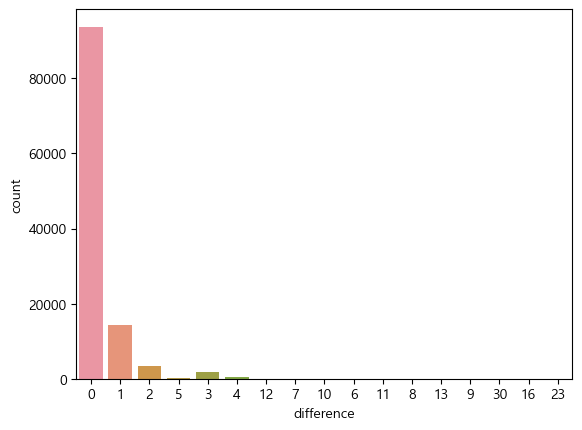

In [21]:
# 구매 시간과 결제 승인 시간의 차이 확인 -> 차이가 거의 없으면 구매 시간 column drop할 예정!
# 대부분 1~2일 사이에 결제가 완료되는 것을 확인, 따라서 차이가 거의 없으므로 order_purchase_timestamp 컬럼 drop

df['difference'] = df['order_approved_at'] - df['order_purchase_timestamp']

df['difference'] = df['difference'].astype(str)
df['difference'] = df['difference'].apply(lambda x: x.split()[0])

display(sns.countplot(data = df, x= 'difference'))

In [22]:
# 결제 승인 컬럼 기준 파생변수 생성

df["order_approved_at_year"] = df['order_approved_at'].dt.year
df["order_approved_at_month"] = df['order_approved_at'].dt.month
df["order_approved_at_day"] = df['order_approved_at'].dt.day
df["order_approved_at_date"] = df['order_approved_at'].dt.date
df["order_approved_at_hour"] = df['order_approved_at'].dt.hour
df["order_approved_at_weekday"] = df['order_approved_at'].dt.day_name()

# 구매 시간 기준 파생변수 생성

df["order_purchase_timestamp_year"] = df['order_purchase_timestamp'].dt.year
df["order_purchase_timestamp_month"] = df['order_purchase_timestamp'].dt.month
df["order_purchase_timestamp_day"] = df['order_purchase_timestamp'].dt.day
df["order_purchase_timestamp_date"] = df['order_purchase_timestamp'].dt.date
df["order_purchase_timestamp_hour"] = df['order_purchase_timestamp'].dt.hour
# df["order_purchase_timestamp_weekday"] = df['order_purchase_timestamp'].dt.dayofweek
df["order_purchase_timestamp_weekday"] = df['order_purchase_timestamp'].dt.day_name()


zip_code 전처리

4글자 -> 5글자로 만들어주기 위해 0을 추가
- SP주만 '0'으로 시작하는 우편번호 존재, 따라서 SP주만 따로 전처리 필요 (SP주 우편번호 : 01000 to 19990)
- SP주 이외의 주는 모두 5글자로 뒤에 0이 잘 붙어있는 것을 확인, 따라서 SP주는 0을 앞에 붙여주는 전처리를 진행

In [23]:
sp_df = df[df.customer_state == 'SP']
other_df = df[df.customer_state != 'SP']

zip_code_col = [i for i in sp_df.columns if 'zip' in i]
print(zip_code_col)

['customer_zip_code_prefix', 'seller_zip_code_prefix']


(20010, 99980)

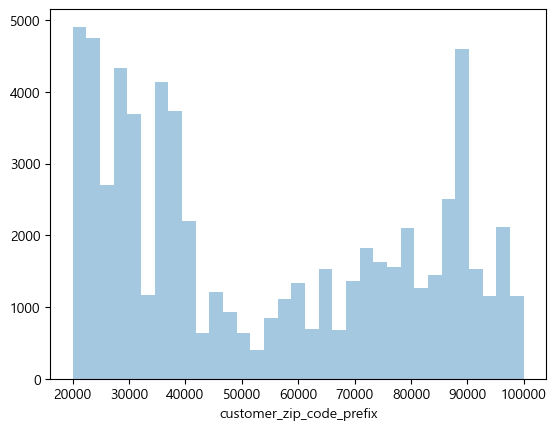

In [24]:
sns.distplot(other_df.customer_zip_code_prefix, kde=False)
min(other_df.customer_zip_code_prefix), max(other_df.customer_zip_code_prefix)

In [25]:
# SP주 변경

sp_df['customer_zip_code_prefix'] = sp_df['customer_zip_code_prefix'].astype(str)
sp_df['customer_zip_code_prefix'] = sp_df['customer_zip_code_prefix'].apply(lambda x: '0' + x if len(x) < 5 else x)

sp_df['seller_zip_code_prefix'] = sp_df['seller_zip_code_prefix'].astype(int)
sp_df['seller_zip_code_prefix'] = sp_df['seller_zip_code_prefix'].astype(str)
sp_df['seller_zip_code_prefix'] = sp_df['seller_zip_code_prefix'].apply(lambda x: '0' + x if len(x) < 5 else x)

In [26]:
min(sp_df.customer_zip_code_prefix), max(sp_df.customer_zip_code_prefix)

('01003', '19970')

In [27]:
sp_df[sp_df.customer_state == 'SP']['customer_zip_code_prefix']

0         03149
1         03149
2         03149
3         03366
4         02290
          ...  
114046    13974
114050    09060
114051    09060
114054    08528
114057    09687
Name: customer_zip_code_prefix, Length: 48116, dtype: object

In [28]:
# data merge

df = pd.concat([sp_df, other_df])

In [29]:
df[df.customer_state == 'SP']['customer_zip_code_prefix']

0         03149
1         03149
2         03149
3         03366
4         02290
          ...  
114046    13974
114050    09060
114051    09060
114054    08528
114057    09687
Name: customer_zip_code_prefix, Length: 48116, dtype: object

product_category_name translation을 사용하여 포루투갈어 -> 영어로 변경

In [43]:
name_translation[:5]

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [30]:
display(df.product_category_name.nunique(), name_translation.product_category_name.nunique())

dif_lst = [i for i in df.product_category_name.unique() if i not in name_translation.product_category_name.unique()]

# project data에는 있는데 name_translation data에 없는 product_category_name인 경우 (2가지)
# 휴대용 주방 음식 냉장고, PC 게임
print(dif_lst)

print(df[df.product_category_name == 'portateis_cozinha_e_preparadores_de_alimentos'].shape)
print(df[df.product_category_name == 'pc_gamer'].shape)

73

71

['pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos']
(14, 54)
(9, 54)


In [31]:
# product_category_name translation : 포루투갈어 -> 영어
# project data에는 있는데 name_translation data에 없는 product_category_name인 경우 (2가지)가 총 25건수로 매우 적은 데이터여서 drop

df = df.merge(name_translation, on ='product_category_name', how = 'left')
df = df.drop(df[df.product_category_name_english.isna()].index)

## 불필요한 컬럼 drop

In [ ]:
df1 = df.copy()
df1.columns

In [34]:
# order_status가 delivered 하나 -> drop
# order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date 파생 변수 만들었으니 drop
# df1 = df.copy()

del_col = ['difference', 'order_status', 
        'order_delivered_carrier_date', 'order_delivered_customer_date',
        'order_estimated_delivery_date', 'shipping_limit_date',  
        'product_category_name']
df1 = df1.drop(columns=del_col)

# 특정 역할의 id column 제외하고 merge에 사용한 id columns drop
id_col = [i for i in df1.columns if 'id' in i]
id_col.remove('order_item_id')
id_col.remove('customer_unique_id')
df1 = df1.drop(columns=id_col)

In [35]:
print(df.shape, df1.shape)

# nuniuqe값이 1인 경우 확인 -> 1이면 drop / 없는 것을 확인
df1.nunique()[df1.nunique() == 1]

(114035, 55) (114035, 42)


Series([], dtype: int64)

In [36]:
df1 = df1.rename(columns={'product_category_name_english' : 'product_category'})

In [39]:
df1.shape

(114035, 42)

In [40]:
# 컬럼별 전처리 완료, data 저장

df1.to_csv('../Data_e-commerce/col_preprocessing_complete.csv', index = False)
# df1.to_excel(excel_writer = 'col_preprocessing_complete.xlsx', index= False)